## 01_Setup

In [74]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
import os

gpt4o_chat = AzureChatOpenAI(
    openai_api_version="2024-05-01-preview",
    azure_deployment="gpt-4o",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
)
# deployment_name = "gpt-4o"
messages = [HumanMessage(content="Hello world", name="Siri")]
response = gpt4o_chat.invoke(messages)
print(response)

content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_f3927aa00d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_materi

In [75]:
gpt4o_chat.invoke("Hello my name is Siri")

AIMessage(content='Hello Siri! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 12, 'total_tokens': 22, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_65792305e4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filte

In [76]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

In [77]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)
search_docs = tavily_search.invoke("What is LangGraph?")

In [78]:
search_docs

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner.'},
 {'url': 'https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/',
  'content': 'Presenting LangGraph, a revolutionary library that aims to revolutionize AI agent building and runtime execution. Overview. LangGraph is a library built on top of Langchain that is designed to facilitate the creation of cyclic graphs for large language model (LLM) - based AI agents.'},
 {'url': 'https://telestreak.com/tech/ai/langgraph-introduction-and-when-is-it-beneficial/',
  'content': "LangGraph is a Python-based framework that enables developers to create sophisticated, multi-step workflows for AI models. We want to build an AI-powered text processor system using LangGra

## 02_Simple Graph

Let's build a simple graph with 3 nodes and one conditional edge. 

![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

### State: 

[State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)  

The State schema serves as the input schema for all Nodes and Edges in the graph.

In [79]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

### Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions.

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.

Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

In [80]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

### Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges) are used want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [81]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

### Graph Construction

Now, we build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above.

The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above.
 
Then, we add our nodes and edges.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. 

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

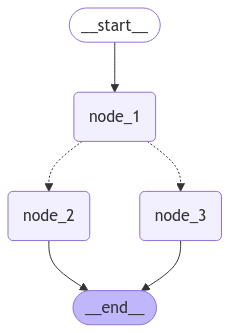

In [82]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/) protocol.

This provides a standard way to execute LangChain components. 
 
`invoke` is one of the standard methods in this interface.

The input is a dictionary `{"graph_state": "Hi, this is lance."}`, which sets the initial value for our graph state dict.

When `invoke` is called, the graph starts execution from the `START` node.

It progresses through the defined nodes (`node_1`, `node_2`, `node_3`) in order.

The conditional edge will traverse from node `1` to node `2` or `3` using a 50/50 decision rule. 

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the `END` node.

In [83]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Lance. I am sad!'}

`invoke` runs the entire graph synchronously.

This waits for each step to complete before moving to the next.

It returns the final state of the graph after all nodes have executed.

In this case, it returns the state after `node_3` has completed: 

```
{'graph_state': 'Hi, this is Lance. I am sad!'}
```

## 03_Chain


Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

### Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [84]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


### Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

In [85]:
llm=gpt4o_chat
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [86]:
result

AIMessage(content="One of the best places to see orcas in the United States is the waters around the San Juan Islands in Washington State. This region is renowned for its diverse marine life and is one of the prime locations for orca whale watching, especially between the months of May and September. The resident orca pods, known as the Southern Residents, are frequently seen here, and there are many tour operators offering whale-watching excursions.\n\nOther notable locations for orca sightings in the US include:\n- Puget Sound, Washington: Besides the San Juan Islands, the surrounding Puget Sound area also provides opportunities to see orcas.\n- Monterey Bay, California: This area is known for its diverse marine ecosystem, and transient orcas can be spotted occasionally.\n- Gulf of Alaska: Orcas are found in the waters off Alaska, particularly around Kenai Fjords National Park and Glacier Bay.\n\nWhen planning a whale-watching trip, it's always good to check with local tour operators

In [87]:
result.response_metadata

{'token_usage': {'completion_tokens': 209,
  'prompt_tokens': 67,
  'total_tokens': 276,
  'completion_tokens_details': None,
  'prompt_tokens_details': None},
 'model_name': 'gpt-4o-2024-05-13',
 'system_fingerprint': 'fp_65792305e4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'jailbreak': {'filtered': False, 'detected': False},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'finish_reason': 'stop',
 'logprobs': None,
 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
  'protected_material_code': {'filtered': False, 'detected': False},
  'protected_material_text': {'filtered': False, 'detected': False},
  'self_harm': {'filtered': False, 'severity': 'safe'},
  'sexual': {'filtered': False, 'severity': 'safe'},
  'violence': {'filtered': False, 'seve

### Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [88]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [89]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1MEm2d1K9kjkLV6WV7267lQz', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 62, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_f3927aa00d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id=

In [90]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_1MEm2d1K9kjkLV6WV7267lQz',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

### Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [91]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

### Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [92]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [93]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [94]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='085428e9-7734-4839-8384-343a630ec7b2'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='127a07c5-d5d8-450d-91e4-6642689c07ec'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='cd5e86d2-c99d-4b09-a4c9-5c9c4b313816')]

### Our graph

Now, lets use `MessagesState` with a graph.

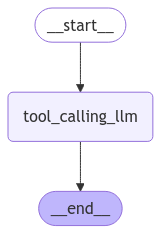

In [95]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [96]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [97]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_147v7jOpigZyLNHQ0lWT5c7G)
 Call ID: call_147v7jOpigZyLNHQ0lWT5c7G
  Args:
    a: 2
    b: 3


## 04_Router

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is an simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly. 

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output! 

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model model output, and route to our tool calling node or simply end if no tool call is performed. 



In [98]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it. 
 
 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

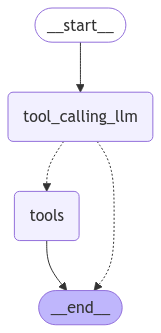

In [99]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [100]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello world.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello world.
================================== Ai Message ==================================

Hello! How can I assist you today?


Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`. 

### Review
We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## 05_Agent

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools. 

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [101]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [102]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

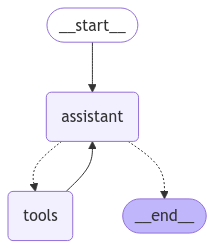

In [103]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [104]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [105]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_vplxZG3zUXvPNRDAUTjUFLzD)
 Call ID: call_vplxZG3zUXvPNRDAUTjUFLzD
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_CCq4adXtNTEdhriOFRw1o9VK)
 Call ID: call_CCq4adXtNTEdhriOFRw1o9VK
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_Kg6gzakSglmwRYScjdmbbDzg)
 Call ID: call_Kg6gzakSglmwRYScjdmbbDzg
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

### Review

We built an agent that can:

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## 06_Agent Memory

Now, we're going extend our agent by introducing memory.

In [106]:

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# To Maintain same way
llm=gpt4o_chat
tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

In [107]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

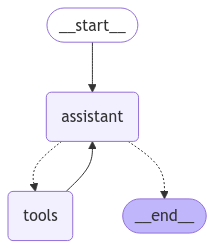

In [108]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

### Memory

In [109]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_UfDCfrBtPXbyAD6YRgO4fj4T)
 Call ID: call_UfDCfrBtPXbyAD6YRgO4fj4T
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


In [110]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

Could you please provide the number you'd like to multiply by 2?


We are not retaining memory from previous. It was 7

We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions. 

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [111]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [112]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_Ep0T3Q7kVAWyzylUuzsbRXS5)
 Call ID: call_Ep0T3Q7kVAWyzylUuzsbRXS5
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [113]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_Ep0T3Q7kVAWyzylUuzsbRXS5)
 Call ID: call_Ep0T3Q7kVAWyzylUuzsbRXS5
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_wMLw1Un96slKWsADbZMKf7Wl)
 Call ID: call_wMLw1Un96slKWsADbZMKf7Wl
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

Typically, all graph nodes communicate with a single schema. 

Also, this single schema contains the graph's input and output keys / channels.

But, there are cases where we may want a bit more control over this:

* Internal nodes may pass information that is *not required* in the graph's input / output.

* We may also want to use different input / output schemas for the graph. The output might, for example, only contain a single relevant output key.

We'll discuss a few ways to customize graphs with multiple schemas.

# 07_State Schema

We built up to an agent that can: 

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)
* `persist state` - use an in memory checkpointer to support long-running conversations with interruptions

Now we're going to build a deeper understanding of both state and memory.

## Schema

When we define a LangGraph `StateGraph`, we use a [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

The state schema represents the structure and types of data that our graph will use.

All nodes are expected to communicate with that schema.

LangGraph offers flexibility in how you define your state schema, accommodating various Python [types](https://docs.python.org/3/library/stdtypes.html#type-objects) and validation approaches!

## TypedDict

As we mentioned in Module 1, we can use the `TypedDict` class from python's `typing` module.

It allows you to specify keys and their corresponding value types.
 
But, note that these are type hints. 

They can used by static type checkers (like [mypy](https://github.com/python/mypy)) or IDEs to catch potential type-related errors before the code is run. 

But they are not enforced at runtime!

In [114]:
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: str

For more specific value constraints, you can use things like the `Literal` type hint.

Here, `mood` can only be either "happy" or "sad".

In [115]:
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy","sad"]

We can use our defined state class (e.g., here `TypedDictState`) in LangGraph by simply passing it to `StateGraph`.

And, we can think about each state key just a "channel" in our graph. 

As discussed in Module 1, we overwrite the value of a specified key or "channel" in each node.

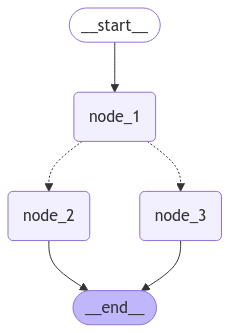

In [116]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:
        
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Because our state is a dict, we simply invoke the graph with a dict to set an initial value of the `name` key in our state.

In [117]:
graph.invoke({"name":"Lance"})

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}

## Dataclass

Python's [dataclasses](https://docs.python.org/3/library/dataclasses.html) provide [another way to define structured data](https://www.datacamp.com/tutorial/python-data-classes).

Dataclasses offer a concise syntax for creating classes that are primarily used to store data.

In [118]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    mood: Literal["happy","sad"]

To access the keys of a `dataclass`, we just need to modify the subscripting used in `node_1`: 

* We use `state.name` for the `dataclass` state rather than `state["name"]` for the `TypedDict` above

You'll notice something a bit odd: in each node, we still return a dictionary to perform the state updates.
 
This is possible because LangGraph stores each key of your state object separately.

The object returned by the node only needs to have keys (attributes) that match those in the state!

In this case, the `dataclass` has key `name` so we can update it by passing a dict from our node, just as we did when state was a `TypedDict`.

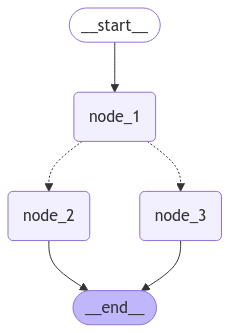

In [119]:
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}

# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We invoke with a `dataclass` to set the initial values of each key / channel in our state!

In [120]:
graph.invoke(DataclassState(name="Lance",mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

## Pydantic

As mentioned, `TypedDict` and `dataclasses` provide type hints but they don't enforce types at runtime. 
 
This means you could potentially assign invalid values without raising an error!

For example, we can set `mood` to `mad` even though our type hint specifies `mood: list[Literal["happy","sad"]]`.

In [121]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str # "happy" or "sad" 

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error


We can use `PydanticState` in our graph seamlessly. 

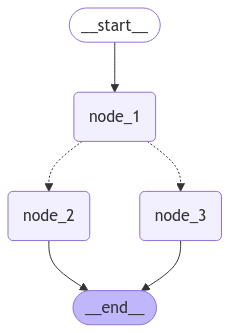

In [122]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [123]:
graph.invoke(PydanticState(name="Lance",mood="sad"))

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}

# 08_State Reducers 

Now, we're going to dive into reducers, which specify how state updates are performed on specific keys / channels in the state schema.

## Default overwriting state

Let's use a `TypedDict` as our state schema.

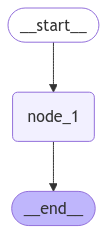

In [124]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [125]:
graph.invoke({"foo" : 1})

---Node 1---


{'foo': 2}

Let's look at the state update, `return {"foo": state['foo'] + 1}`.

As discussed before, by default LangGraph doesn't know the preferred way to update the state.
 
So, it will just overwrite the value of `foo` in `node_1`: 

```
return {"foo": state['foo'] + 1}
```
 
If we pass `{'foo': 1}` as input, the state returned from the graph is `{'foo': 2}`.

## Branching

Let's look at a case where our nodes branch.

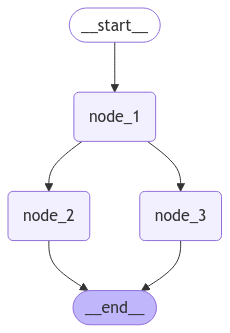

In [126]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [127]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


We see a problem! 

Node 1 branches to nodes 2 and 3.

Nodes 2 and 3 run in parallel, which means they run in the same step of the graph.

They both attempt to overwrite the state *within the same step*. 

This is ambiguous for the graph! Which state should it keep? 

## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function. 

For example, in this case let's append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

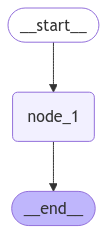

In [128]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [129]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

Now, our state key `foo` is a list.

This `operator.add` reducer function will append updates from each node to this list. 

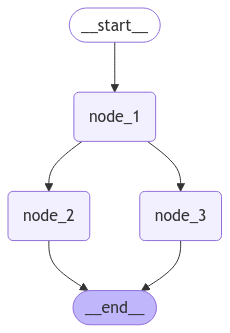

In [130]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

In [131]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

Now, let's see what happens if we pass `None` to `foo`.

We see an error because our reducer, `operator.add`, attempts to concatenate `NoneType` pass as input to list in `node_1`. 

In [132]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## Custom Reducers

To address cases like this, [we can also define custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state). 

For example, lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be `None`.

In [133]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

In `node_1`, we append the value 2.

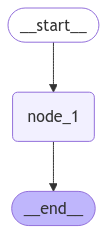

TypeError occurred: can only concatenate list (not "NoneType") to list


In [134]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

Now, try with our custom reducer. We can see that no error is thrown.

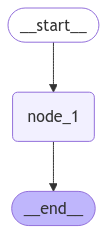

---Node 1---
{'foo': [2]}


In [135]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## Messages

In module 1, we showed how to use a built-in reducer, `add_messages`, to handle messages in state.

We also showed that [`MessagesState` is a useful shortcut if you want to work with messages](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate). 

* `MessagesState` has a built-in `messages` key 
* It also has a built-in `add_messages` reducer for this key

These two are equivalent. 

We'll use the `MessagesState` class via `from langgraph.graph import MessagesState` for brevity.


In [136]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str
    # etc

Let's talk a bit more about usage of the `add_messages` reducer.

In [137]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='3f78377d-8ba6-4bc6-acaa-a1571ee0290f'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='71bb310a-6301-40d9-9a86-2c16b961fb36'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='331c91af-16b0-4440-b4de-4f2ef9cf06fe')]

So we can see that `add_messages` allows us to append messages to the `messages` key in our state.

### Re-writing

Let's show some useful tricks when working with the `add_messages` reducer.

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten!

In [138]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

### Removal

`add_messages` also [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/). 

For this, we simply use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core`.

In [139]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [140]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

We can see that mesage IDs 1 and 2, as noted in `delete_messages` are removed by the reducer.

We'll see this put into practice a bit later.

# 09_Multiple Schemas 

Typically, all graph nodes communicate with a single schema. 

Also, this single schema contains the graph's input and output keys / channels.

But, there are cases where we may want a bit more control over this:

* Internal nodes may pass information that is *not required* in the graph's input / output.

* We may also want to use different input / output schemas for the graph. The output might, for example, only contain a single relevant output key.

We'll discuss a few ways to customize graphs with multiple schemas.

## Private State

First, let's cover the case of passing [private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) between nodes.

This is useful for anything needed as part of the intermediate working logic of the graph, but not relevant for the overall graph input or output.

We'll define an `OverallState` and a `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

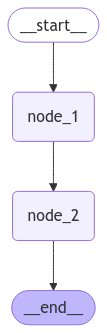

In [141]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [142]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---


{'foo': 3}

`baz` is only included in `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

So, we can see that `baz` is excluded from the graph output because it is not in `OverallState`.

## Input / Output Schema

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema. 

However, it is also possible to [define explicit input and output schemas for a graph](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

Often, in these cases, we define an "internal" schema that contains *all* keys relevant to graph operations.

But, we use specific `input` and `output` schemas to constrain the input and output.

First, let's just run the graph with a single schema.

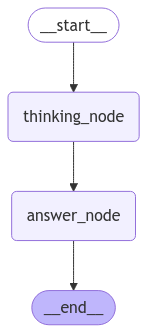

In [143]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState):
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Notice that the output of invoke contains all keys in `OverallState`. 

In [144]:
graph.invoke({"question":"hi"})

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his is name is Lance'}

Now, let's use a specific `input` and `output` schema with our graph.

Here, `input` / `output` schemas perform *filtering* on what keys are permitted on the input and output of the graph. 

In addition, we can use a type hint `state: InputState` to specify the input schema of each of our nodes.

This is important when the graph is using multiple schemas.

We use type hints below to, for example, show that the output of `answer_node` will be filtered to `OutputState`. 

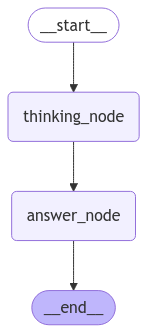

{'answer': 'bye Lance'}

In [145]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

We can see the `output` schema constrains the output to only the `answer` key.